Build a predictive model for qualifying lap times that:

- Uses data from multiple seasons (2023–2025), not just one session

- Incorporates circuit characteristics, driver performance, and environmental factors

- Can generalize across circuits and seasons

For each qualifying session:

- Driver, Team

- LapTime, LapNumber, Stint, TyreLife, FreshTyre, Compound

- Sector1Time, Sector2Time, Sector3Time

- TrackTemp, AirTemp

- Year and circuit location

Custom circuit information (your CSV)

- Static circuit descriptors:
TrackLength, NumTurns, RaceDistance, NumLaps, TyreStress,
AsphaltGrip, Downforce, Braking, LateralLoad, etc.

- Pirelli tyre choices: Soft, Medium, Hard (mapped to C1–C6 scale)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
FILE_2025 = 'features_laps_2025.csv'
FILE_2024 = 'features_laps_2024.csv'
FILE_2023 = 'features_laps_2023.csv'

In [ ]:
features_25 = pd.read_csv(FILE_2025, delimiter=',')
features_24 = pd.read_csv(FILE_2024, delimiter=',')
features_23 = pd.read_csv(FILE_2023, delimiter=',')

In [9]:
features = pd.concat([features_25, features_24, features_23], ignore_index=True)

In [15]:
features.to_csv('features_laps.csv', index=False)

In [13]:
remove_2025 = ['Austin', 'Mexico City', 'São Paulo', 'Las Vegas', 'Lusail', 'Yas Island']

features = features[~((features['Year'] == 2025) & (features['Location'].isin(remove_2025)))]

In [14]:
features['Year'].value_counts()

Year
2023    2309
2024    2285
2025    1679
Name: count, dtype: int64

## Encoding

In [45]:
features_encoded = pd.get_dummies(features, columns=['Driver','Team','Location'], drop_first=False)

In [47]:
def map_compound(row):
    if row['Compound'] == 'SOFT':
        return row['Soft']
    elif row['Compound'] == 'MEDIUM':
        return row['Medium']
    elif row['Compound'] == 'HARD':
        return row['Hard']
    else:
        return None
    
features_encoded['Compound'] = features_encoded.apply(map_compound, axis=1)

compound_map = {'C6' : 6, 'C5' : 5, 'C4' : 4, 'C3' : 3, 'C2' : 2, 'C1' : 1} # wet = 0
features_encoded['Compound'] = features_encoded['Compound'].map(compound_map).fillna(0)

In [55]:
features_encoded = features_encoded.drop(columns=['Country','EventDate','EventName','Soft','Medium','Hard'])

In [56]:
features_encoded.loc[features_encoded['TyreLife'].isna() & (features_encoded['FreshTyre'] == True), 'TyreLife'] = 2.0
features_encoded.loc[features_encoded['TyreLife'].isna() & (features_encoded['FreshTyre'] == False), 'TyreLife'] = 3.0

In [57]:
nan_summary = features_encoded.isna().sum()
nan_summary = nan_summary[nan_summary > 0]
print(nan_summary)

Series([], dtype: int64)


In [58]:
features_encoded.to_csv('features_laps_encoded.csv', index=False)

In [59]:
features_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6273 entries, 0 to 6752
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LapTime                     6273 non-null   float64
 1   LapNumber                   6273 non-null   float64
 2   Stint                       6273 non-null   float64
 3   TyreLife                    6273 non-null   float64
 4   FreshTyre                   6273 non-null   bool   
 5   Compound                    6273 non-null   float64
 6   TrackTemp                   6273 non-null   float64
 7   AirTemp                     6273 non-null   float64
 8   Sector1Time                 6273 non-null   float64
 9   Sector2Time                 6273 non-null   float64
 10  Sector3Time                 6273 non-null   float64
 11  Year                        6273 non-null   int64  
 12  TrackLenght                 6273 non-null   float64
 13  NumTurns                    6273 non-n

## Model Training and Evaluation

In [ ]:
from sklearn.preprocessing import StandardScaler

In [60]:
from sklearn.model_selection import train_test_split

X = features_encoded.drop(columns=['LapTime'])
y = features_encoded['LapTime']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [62]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.3f} seconds")
print(f"RMSE: {rmse:.3f} seconds")

MAE: 0.117 seconds
RMSE: 0.256 seconds


In [64]:
pred_df = X_test.copy()
pred_df['PredictedLapTime'] = y_pred
pred_df['Driver'] = features.loc[X_test.index, 'Driver']


In [75]:
pred_dff = X_test.copy()  # copy the features used for prediction
pred_dff['ActualLapTime'] = y_test.values
pred_dff['PredictedLapTime'] = y_pred
pred_dff['Driver'] = features.loc[X_test.index, 'Driver']
pred_dff['Team'] = features.loc[X_test.index, 'Team']
pred_dff['Location'] = features.loc[X_test.index, 'Location']


cols_to_keep = ['Driver', 'Team', 'LapNumber', 'Stint', 'Compound', 
                'PredictedLapTime', 'ActualLapTime', 'Location', 'Year']
pred_dff = pred_dff[cols_to_keep]

In [78]:
pred_dff_sorted = pred_dff.sort_values(by=['Year', 'Location', 'PredictedLapTime'])

In [85]:
pred_dff_diff = pred_dff.copy()
pred_dff_diff['Difference'] = pred_dff_diff['ActualLapTime'] - pred_dff_diff['PredictedLapTime']

# Add a column for absolute difference
pred_dff_diff['AbsDifference'] = pred_dff_diff['Difference'].abs()

# Sort by absolute difference
pred_dff_diff_sorted = pred_dff_diff.sort_values(by='AbsDifference')

In [86]:
pred_dff_diff

,Driver,Team,LapNumber,Stint,Compound,PredictedLapTime,ActualLapTime,Location,Year,Difference,AbsDifference
3643,STR,Aston Martin,18.0,5.0,4.0,70.81363,70.857,Zandvoort,2024,0.04337,0.04337
2373,HUL,Haas F1 Team,5.0,2.0,3.0,89.72945,89.821,Suzuka,2024,0.09155,0.09155
4170,LAW,RB,5.0,1.0,5.0,94.78228,94.842,Las Vegas,2024,0.05972,0.05972
2183,ZHO,Kick Sauber,5.0,1.0,5.0,78.10452,78.188,Melbourne,2024,0.08348,0.08348
5690,PIA,McLaren,19.0,5.0,4.0,87.84394,87.845,Silverstone,2023,0.00106,0.00106
...,...,...,...,...,...,...,...,...,...,...,...
3503,SAI,Ferrari,9.0,2.0,5.0,78.23511,78.265,Budapest,2024,0.02989,0.02989
3239,PER,Red Bull Racing,17.0,6.0,5.0,65.41363,65.504,Spielberg,2024,0.09037,0.09037
5721,STR,Aston Martin,15.0,5.0,4.0,111.74204,112.193,Spa-Francorchamps,2023,0.45096,0.45096
106,HAD,Racing Bulls,4.0,2.0,4.0,91.64044,91.824,Shanghai,2025,0.18356,0.18356


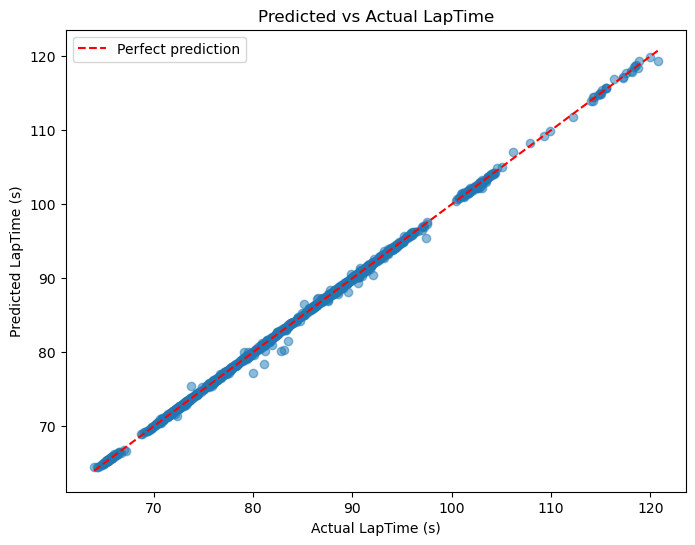

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect prediction')
plt.xlabel('Actual LapTime (s)')
plt.ylabel('Predicted LapTime (s)')
plt.title('Predicted vs Actual LapTime')
plt.legend()
plt.show()

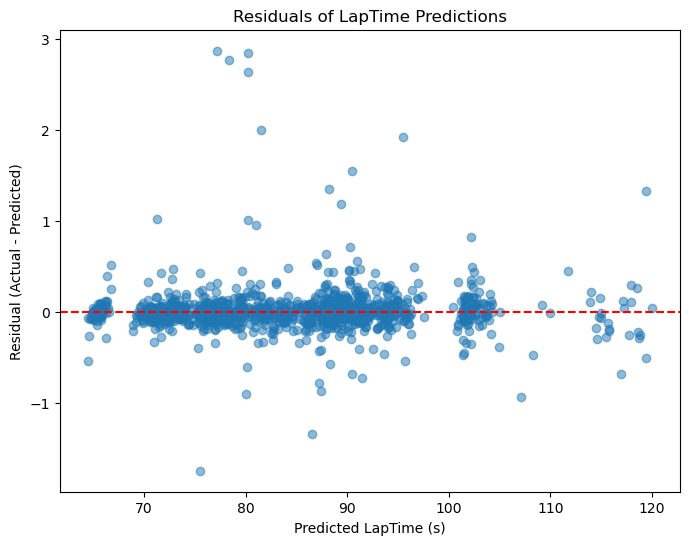

In [80]:
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted LapTime (s)')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals of LapTime Predictions')
plt.show()